## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ImportError: cannot import name 'triu' from 'scipy.linalg' (/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/scipy/linalg/__init__.py)

In [2]:
# load data 
# ----------
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(n=1000)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
632508,1.124350e+18,WarrenDavidson,2019-05-03T12:29:48-04:00,Today’s jobs report indicates the lowest unemp...,Warren Davidson,Rep,7-Jun-16,3/1/1970,M,OH,8,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
43304,1.324500e+18,RepAndyBiggsAZ,2020-11-05T19:02:02-05:00,There’s no context to your numbers. You have a...,Andy Biggs,Rep,3-Jan-17,11/7/1958,M,AZ,5,Republican,"1,252,401","1,161,167","1,025,232","1,233,654"
564765,1.149750e+18,RepGregoryMeeks,2019-07-12T14:38:35-04:00,RT @RepMaloney My bill to #renew911VCF just pa...,Gregory Meeks,Rep,3-Feb-98,9/25/1953,M,NY,5,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"
933290,1.126910e+18,RepGrothman,2019-05-10T14:00:01-04:00,"Last night, I spoke on the House Floor about t...",Glenn Grothman,Rep,3-Jan-15,7/3/1955,M,WI,6,Republican,"1,405,284","1,382,536","1,620,985","1,407,966"
151336,1.322260e+18,RepMikeLevin,2020-10-30T15:47:19-04:00,Reminder! Now is the time to drop your ballot ...,Mike Levin,Rep,3-Jan-19,10/28/1978,M,CA,49,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"


In [3]:
#Create dictionary for states' 2012 and 2016 election results, store it in dataset because we probably will do some change over time stuff related to RQ2

mappedstates = {}  # Create an empty dictionary to hold state mappings

# Iterate over rows for 2012 data
for index, row in congress_tweets.iterrows():
    if row['obama_2012_state_share'] > row['romney_2012_state_share']:
        mappedstates[row['state']] = ['Democrat2012', None]  # Assign Democrat for 2012
    else:
        mappedstates[row['state']] = ['Republican2012', None]  # Assign Republican for 2012

# Iterate over rows for 2016 data and update mappings
for index, row in congress_tweets.iterrows():
    if row['clinton_2016_state_share'] > row['trump_2016_state_share']:
        mappedstates[row['state']][1] = 'Democrat2016'  # Update 2016 to Democrat
    else:
        mappedstates[row['state']][1] = 'Republican2016'  # Update 2016 to Republican

# Create new columns for party affiliation in 2012 and 2016
congress_tweets['party_2012'] = congress_tweets['state'].map(lambda state: mappedstates.get(state, [None, None])[0])
congress_tweets['party_2016'] = congress_tweets['state'].map(lambda state: mappedstates.get(state, [None, None])[1])

# Check the updated DataFrame
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,party_2012,party_2016
632508,1.124350e+18,WarrenDavidson,2019-05-03T12:29:48-04:00,Today’s jobs report indicates the lowest unemp...,Warren Davidson,Rep,7-Jun-16,3/1/1970,M,OH,8,Republican,"2,841,005","2,394,164","2,827,709","2,661,437",Democrat2012,Republican2016
43304,1.324500e+18,RepAndyBiggsAZ,2020-11-05T19:02:02-05:00,There’s no context to your numbers. You have a...,Andy Biggs,Rep,3-Jan-17,11/7/1958,M,AZ,5,Republican,"1,252,401","1,161,167","1,025,232","1,233,654",Republican2012,Republican2016
564765,1.149750e+18,RepGregoryMeeks,2019-07-12T14:38:35-04:00,RT @RepMaloney My bill to #renew911VCF just pa...,Gregory Meeks,Rep,3-Feb-98,9/25/1953,M,NY,5,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",Democrat2012,Democrat2016
933290,1.126910e+18,RepGrothman,2019-05-10T14:00:01-04:00,"Last night, I spoke on the House Floor about t...",Glenn Grothman,Rep,3-Jan-15,7/3/1955,M,WI,6,Republican,"1,405,284","1,382,536","1,620,985","1,407,966",Democrat2012,Republican2016
151336,1.322260e+18,RepMikeLevin,2020-10-30T15:47:19-04:00,Reminder! Now is the time to drop your ballot ...,Mike Levin,Rep,3-Jan-19,10/28/1978,M,CA,49,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",Democrat2012,Democrat2016


In [4]:
#Play around with temporal variables
congress_tweets['joined_congress_date'] = pd.to_datetime(congress_tweets['joined_congress_date'], format='%d-%b-%y')

congress_tweets['birthday'] = pd.to_datetime(congress_tweets['birthday'], format='%m/%d/%Y')

congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,party_2012,party_2016
632508,1.124350e+18,WarrenDavidson,2019-05-03T12:29:48-04:00,Today’s jobs report indicates the lowest unemp...,Warren Davidson,Rep,2016-06-07,1970-03-01,M,OH,8,Republican,"2,841,005","2,394,164","2,827,709","2,661,437",Democrat2012,Republican2016
43304,1.324500e+18,RepAndyBiggsAZ,2020-11-05T19:02:02-05:00,There’s no context to your numbers. You have a...,Andy Biggs,Rep,2017-01-03,1958-11-07,M,AZ,5,Republican,"1,252,401","1,161,167","1,025,232","1,233,654",Republican2012,Republican2016
564765,1.149750e+18,RepGregoryMeeks,2019-07-12T14:38:35-04:00,RT @RepMaloney My bill to #renew911VCF just pa...,Gregory Meeks,Rep,1998-02-03,1953-09-25,M,NY,5,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",Democrat2012,Democrat2016
933290,1.126910e+18,RepGrothman,2019-05-10T14:00:01-04:00,"Last night, I spoke on the House Floor about t...",Glenn Grothman,Rep,2015-01-03,1955-07-03,M,WI,6,Republican,"1,405,284","1,382,536","1,620,985","1,407,966",Democrat2012,Republican2016
151336,1.322260e+18,RepMikeLevin,2020-10-30T15:47:19-04:00,Reminder! Now is the time to drop your ballot ...,Mike Levin,Rep,2019-01-03,1978-10-28,M,CA,49,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",Democrat2012,Democrat2016


In [5]:
#Obviously a person's name does not change, even if their screen name does. What we want to do is capture all the screen names associated with a particular individual

#Create a mapping dictionary from screen_name to name_wikipedia
screenname_to_wiki = dict(zip(congress_tweets['screen_name'], congress_tweets['name_wikipedia']))

# Use the dictionary to map the values
congress_tweets['mapped_wikipedia'] = congress_tweets['screen_name'].map(screenname_to_wiki)

# Check the result
print(congress_tweets[['screen_name', 'mapped_wikipedia']].head())

            screen_name mapped_wikipedia
632508   WarrenDavidson  Warren Davidson
43304    RepAndyBiggsAZ       Andy Biggs
564765  RepGregoryMeeks    Gregory Meeks
933290      RepGrothman   Glenn Grothman
151336     RepMikeLevin       Mike Levin


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [6]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [7]:
# apply the function to the 'text' i.e. tweet column
# ----------
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x)) # can use apply here 
congress_tweets['tokens'] # visualize

632508    [Today, jobs, report, indicates, lowest, unemp...
43304     [There, context, numbers, You, absolutely, int...
564765    [RT, RepMaloney, My, bill, renew911VCF, passed...
933290    [Last, night, I, spoke, House, Floor, crisis, ...
151336    [Reminder, Now, time, drop, ballot, official, ...
                                ...                        
612807    [The, practice, illegal, 1970, happens, United...
353219                                    [sassywithmassie]
442511                [SOMNLaura, NorthernStarBSA, Awesome]
132621    [Stand, counted, \n\n, Thanks, Norwalk, hostin...
611205    [I, Just, wrapped, great, visit, Yadkin, Valle...
Name: tokens, Length: 1000, dtype: object

In [8]:
## Create function
import spacy
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import re

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

def rem_punc_stop(text):
    stop_words = STOP_WORDS  # List of common stopwords in English
    punc = set(punctuation)  # Set of punctuation characters
    
    # Remove newline characters
    text = text.replace( '\n',' ') 
    
    #Remove whitespace
    space = re.sub(r'\s+', '', text)
    
    # Remove punctuation
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    # Process the text with SpaCy
    doc = nlp(punc_free)
    
    # Get all words, excluding URLs and stop words
    spacy_words = [token.text for token in doc if not token.like_url]
    
    # Filter out stop words
    no_punc = [word for word in spacy_words if word.lower() not in stop_words]
    
    return no_punc


In [9]:
# reapply 
# ----------
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x)) # can use apply here 
congress_tweets['tokens'] # visualize

632508    [Today, jobs, report, indicates, lowest, unemp...
43304     [context, numbers, absolutely, interest, findi...
564765    [RT, RepMaloney, bill, renew911VCF, passed, Ho...
933290    [night, spoke, House, Floor, crisis, Southern,...
151336    [Reminder, time, drop, ballot, official, drop,...
                                ...                        
612807    [practice, illegal, 1970, happens, United, Sta...
353219    [sassywithmassie, httppbstwimgcommediaEa9fAOX0...
442511                [SOMNLaura, NorthernStarBSA, Awesome]
132621    [Stand, counted,   , Thanks, Norwalk, hosting,...
611205    [wrapped, great, visit, Yadkin, Valley, Career...
Name: tokens, Length: 1000, dtype: object

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1

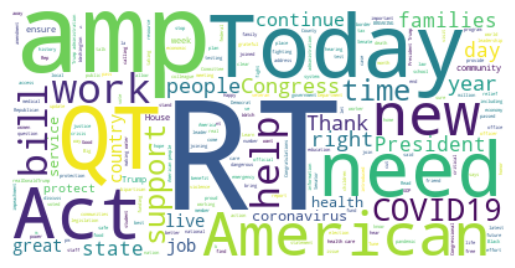

In [10]:
# apply function to text object
from wordcloud import WordCloud
import matplotlib.pyplot as plt
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(background_color = "white",  # set background color to white
                      random_state=41              # set random state to ensure same word cloud each time
                      ).generate(text)             # change the background color


# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

### EDA 2

In [ ]:
...

### Retweets and Quote Tweets

I think that retweets and quote tweets are meaningful signals, though we might not want to have them messing up our sentiment analysis. 
First, let's pull them out to see how prevalent they actually are

In [11]:
# Find all tweets containing "RT" or "QT"
RTtweets = congress_tweets[congress_tweets['text'].str.contains('RT', na=False)]
QTtweets = congress_tweets[congress_tweets['text'].str.contains('QT', na=False)]

# Print the count of retweets and quote tweets
print(f"Number of tweets containing Retweets: {RTtweets.shape[0]}")
print(f"Number of tweets containing Quote tweets: {QTtweets.shape[0]}")

Number of tweets containing Retweets: 246
Number of tweets containing Quote tweets: 143


Now there are some analytic choices here. 
For quote tweets, we will probably need to conceptualize this as a conversation, where the sentiment/message of the original tweet can be the opposite of the re-poster.
However, should 'simple' re-tweets be considered representative of the person doing the re-tweeting? 
Or should they be attributed to the original speaker(s) instead? What should we do if multiple people are being referenced?
Let's see if people are re-tweeting/quote-tweeting other individuals who are also in our database. As we can only reasonably infer characteristics about people being re-tweeted if they are in our database already.

In [12]:
repost_users = congress_tweets[congress_tweets['text'].str.contains('@', na=False)]

print(repost_users[['text']].head())

# Print the count of tweets with an @
print(f"Total number of tweets containing an @: {repost_users.shape[0]}")

                                                     text
43304   There’s no context to your numbers. You have a...
564765  RT @RepMaloney My bill to #renew911VCF just pa...
350799  @jenbrea Genuine question: how does spreading ...
719681  RT @RIDeptEd We will continue to provide updat...
112797  RT @IvankaTrump Practical steps every American...
Total number of tweets containing an @: 594


In [13]:
import re

mentionedusers = {}  # Create an empty dictionary to hold mentions and associated tweet text

# Iterate over rows of congress_tweets
for index, row in congress_tweets.iterrows():
    # Extract mentions (users starting with @) from the tweet text
    mentions = re.findall(r'@([a-zA-Z0-9_]+)', row['text'])
    
    # Check if any of the mentions are in the congress_tweets['screen_name'] list
    for mention in mentions:
        if mention in congress_tweets['screen_name'].values:
            # Find the political affiliation of the person doing the mentioning (the tweet author)
            mentioner_affiliation = congress_tweets.loc[congress_tweets['screen_name'] == row['screen_name'], 'party'].values[0]
            
            # Find the political affiliation of the person being mentioned
            mentioned_affiliation = congress_tweets.loc[congress_tweets['screen_name'] == mention, 'party'].values[0]
            
            # Store the tweet text, the mentioner’s political affiliation, and the mentioned person’s political affiliation in the dictionary
            mentionedusers[mention] = {
                'mentioner_screen_name': row['screen_name'],  # Add mentioner's screen name
                'mentioner_text': row['text'],
                'mentioner_affiliation': mentioner_affiliation,
                'mentioned_affiliation': mentioned_affiliation
            }

# Print only the first 5 mentions that are in congress_tweets['screen_name'], including political affiliation and the tweet author
for i, (mention, details) in enumerate(mentionedusers.items()):
    if i >= 5:
        break
    print(f"Tweet Author: {details['mentioner_screen_name']}")
    print(f"Author Political Affiliation: {details['mentioner_affiliation']}")
    print(f"Mentioned User: {mention}")
    print(f"Mentioned User Political Affiliation: {details['mentioned_affiliation']}\n")
    print(f"Tweet Text: {details['mentioner_text']}")
    print("_________")
print(f"Number QT, RT, or @'s of people in 'screen_name': {len(mentionedusers)}")

Tweet Author: RepAndyBiggsAZ
Author Political Affiliation: Republican
Mentioned User: RepAndyBiggsAZ
Mentioned User Political Affiliation: Republican

Tweet Text: RT @RepDanBishop I introduced a bill to stop your tax $$ from funding cities/states that cede ground to mobs &amp; promote anarchy (#CHAZ). Thx to @RepMattGaetz, @RepTedBudd &amp; @RepAndyBiggsAZ for their support. See more https://danbishop.house.gov/media/press-releases/bishop-cuts-cash-chaz-cities-promoting-lawless-anarchy
_________
Tweet Author: NydiaVelazquez
Author Political Affiliation: Democrat
Mentioned User: RepMaloney
Mentioned User Political Affiliation: Democrat

Tweet Text: We have already heard of museums in NY having to lay off employees and make other cuts. I am joining my colleagues in supporting emergency funds for these cultural institutions, which employ thousands of NYers. https://twitter.com/repmaloney/status/1241508752886505474 QT @RepMaloney Museums in New York State support 61,000 jobs &amp; play an 

From this, we can see the different ways users are interacting with one another in the form of @'s, retweets, and quote tweets. 

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [63]:
...

Ellipsis

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [ ]:
...

### Engineered Text Features

In [ ]:
# Engineered Features
...

### Bag-of-words or Tf-idf

In [ ]:
# Frequency Based featurization
...

### Word Embedding

In [ ]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [ ]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

In [ ]:
# embedding based featurization
...

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [ ]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
...

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**YOUR ANSWER HERE** ...

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**YOUR ANSWER HERE** ...

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**YOUR ANSWER HERE** ...

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**YOUR ANSWER HERE** ...